# Correlation Analysis: Prelude to Calibration

## Preamble
Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are three considerations:

- __Persistence__, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel).
- __Time irregularities__, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
- __Age uncertainties__, for example comparing two records, each with an ensemble of plausible chronologies (generated, for instance, by a Bayesian age model)
- __Test multiplicity__ aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

Accordingly,  Pyleoclim facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results. We start by loading a few useful packages:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt    
import pyleoclim as pyleo
import numpy as np
import xarray as xr

## A case study from Crystal Cave
In this notebook we reproduce the case of [Hu et al, 2017](http://dx.doi.org/10.1016/j.epsl.2016.11.048), particularly the example of their section 4, which illustrates several of these pitfalls at once. The example illuminates the issue of relying too strongly on correlations between a paleoclimate record and an instrumental field to interpret the record. 
### The Crystal Cave record

The example uses the speleothem record of [McCabe-Glynn et al , 2013](https://www.nature.com/articles/ngeo1862) from Crystal Cave, California, in the Sequoia National Forest. 
We first load and plot this record. Of interest to us is the $\delta^{18}O$ record, which the authors interepret as reflecting sea-surface temperatures in the Kuroshio Extension region of the West Pacific.

In [2]:
crys_path = '../data/Crystal.McCabe-Glynn.2013.lpd'
d = pyleo.Lipd(crys_path)
v=d.to_tso()
cc=pyleo.LipdSeries(v)

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.25 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting paleoData...
extracting: Crystal.McCabe-Glynn.2013
Created time series: 3 entries
0 :  Crystal.McCabe-Glynn.2013 :  depth
1 :  Crystal.McCabe-Glynn.2013 :  age_ad
2 :  Crystal.McCabe-Glynn.2013 :  d18o_vpdb


Enter the number of the variable you wish to use:  2


The time axis has been adjusted to be ascending!


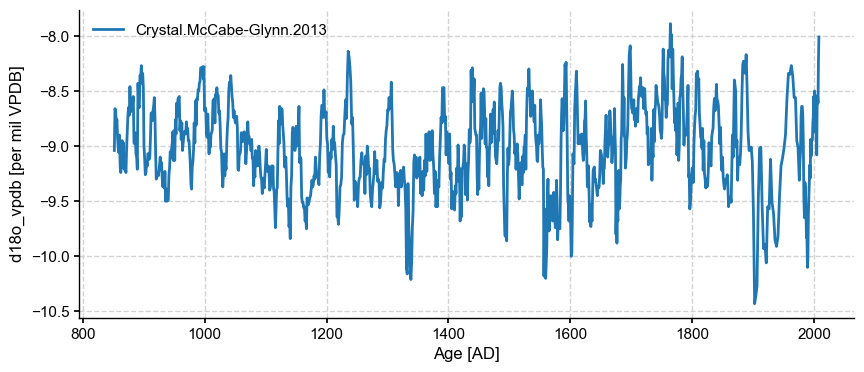

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [AD]', ylabel='d18o_vpdb [per mil VPDB]'>)

In [3]:
cc.plot()

__TODO: add summary plot__

### SST data

The original paper correlated the above record against the Kaplan SST dataset.  In this notebook we instead use the [ERSSTv5 dataset](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html), which is remotely accessible through an [OPenDAP protocol](http://www.opendap.org). We do so via the excellent `xarray` package, showcasing [lazy loading](https://en.wikipedia.org/wiki/Lazy_loading).  

In [4]:
url = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)
print(ds)
lon = ds['lon']
lat = ds['lat']
time = ds['time']
sst = ds['sst']

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 2004)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2020-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    geospatial_lon_min:              -1.0
    geospatial_lon_max: 

Pretty quick, eh? Well, as we said, the data aren't fully loaded yet - only lazy loaded. That means that only the metadata are available at this point. The data will only be downloaded when they're really needed.  

## Pitfall #1: Persistence

Persistence is the tendency of many geophysical timeseries (particularly in paleoclimatology) to show some kind of memory: consecutive observations tend to resemble each other, resulting in timeseries that have fairly broad trends and low-frequency fluctuations, and comparatively little high-frequency fluctuations. 

This has an important consequence: the standard assumption of independence, which undergirds much of frequentist statistics, is violated in this case. In a timeseries with $n$ fully independent observations (e.g. white noise), the degrees of freedom for the variance are $DOF = n -1$  But if memory is present, this number can be drastically reduced. 

### Single location
Let us look at a random location and build some intuition. First, we need to compute montly anomalies and annualize them. `xarray` makes that easy (4 lines of code), so let's look at the result:

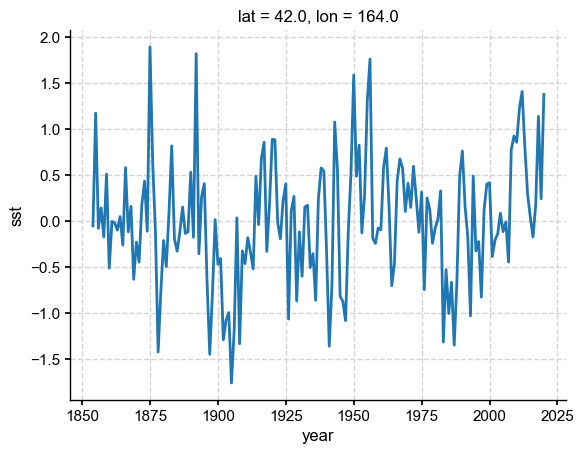

In [13]:
jj = 23
ji= 82
st = sst[:,jj,ji]
climatology = st.groupby("time.month").mean("time")
anomalies = st.groupby("time.month") - climatology
st_annual = anomalies.groupby("time.year").mean("time")
st_annual.plot()
plt.show()

Next we need to pass to to `pyleoclim` as a series object.

In [20]:
stts = pyleo.Series(time=st_annual.coords['year'].values,
                    time_unit ='year CE', 
                    value=st_annual.values,
                    value_unit = 'C')

Now we can compute correlations with the Crystal Cave record. 

In [22]:
corr_res = stts.correlation(cc)
print(corr_res)

{'r': 0.24439588849895444, 'p': 0.119, 'signif': False, 'alpha': 0.05}


Quite a few things happened here. First, `pyleoclim` was smart enough to figure out a common timespan between the two records, and used linear interpolation to align the two timeseries on a common axis. 

The resulting correlation is $r=0.24$. Now, with a standard t-test this might not look so bad.
After all, the test statistic is : $$ T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$

If we plug the numbers in, we get: 

In [39]:
ccs = cc.slice([1854,2020])
n = len(ccs.time)
nu = n-2
r = 0.24
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 2.592924943439165


In [40]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is "+ str(pval))

The p-value is 0.005404800358039807


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that sst at 42N, 164E shares so much similarity with the Crystal Cave record that there are only 5 chances in 1000 that this could have happened randomly. In other words, it looks highly significant! 

Let's take a step back. That test (which is the one that most computing packages, including Excel and Matlab), will do for you out of the box, is completely inappropriate here. Why? Because it tramples over the concept of persistence with gleeful impunity. That is, it assumes that consecutive observations bear no resemblance to each other, which is true neither of 

### All locations together

In [5]:
nlon = len(lon)
nlat = len(lat)

for ji in range(nlon):
    for jj in range(nlat):
        st = sst[:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        

In [ ]:
#check i/m vs. p-values
indexm = np.arange(1,len(pval_975)+1,1)
im = 1.0*indexm / len(pval_975)
thres = 0.05*im
pval_975_s = sorted(pval_975)
#pval_025_s = sorted(pval_025)
smaller=[]
small_index=[]
larger=[]
large_index=[]

n=0
for pp in pval_975_s:
#for pp in pval_025_s:
    if pp <=0.05:
        smaller.append(pp)
        small_index.append(im[n])
    else:
        larger.append(pp)
        large_index.append(im[n])
    n=n+1

plt.plot(im,pval_975_s,'kx',markersize=1.5)
#plt.plot(im,pval_025_s,'kx',markersize=1.5)
plt.plot(im,thres)
plt.plot(small_index,smaller,'bx',markersize=1.5)
plt.plot(large_index,larger,'kx',markersize=1.5)
plt.axhline(y=0.05,linestyle='dashed')
plt.xlabel('index/m',fontsize=14)
plt.ylabel('p-value',fontsize=14)
plt.tick_params(labelsize=14)

## Pitfall #2: Multiple testing

## Pitfall #3: Age uncertainties

In [2]:
tens = ts.chronEnsembleToPaleo(d,0,0)
csv_dict=lpd.getCsv(lipd)

NameError: name 'ts' is not defined